In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch

# Import the decomposition methods
from PyEMD import EMD # For EMD
from sktime.libs.vmdpy import VMD # For VMD
import torch


import os

In [2]:
# Helpers Functions

# THE NEW MVM IMPLEMENTATION USING PYTORCH
def mvmd_torch(signal, alpha, tau, K, DC, init, tol, max_N):
    """
    Multivariate Variational Mode Decomposition (MVMD) implemented in PyTorch.
    
    Parameters:
        signal (torch.Tensor): Input multi-channel signal, shape (C, T).
        alpha (float): Bandwidth parameter (inverse of K).
        tau (float): Dual ascent time step.
        K (int): Number of modes to extract.
        DC (bool): Include DC component.
        init (int): Initialization method (0: all zeros, 1: uniform, 2: random).
        tol (float): Tolerance for convergence.
        max_N (int): Maximum number of iterations.

    Returns:
        u.real (torch.Tensor): Extracted modes, shape (K, T_reduced, C).
        u_hat_final (torch.Tensor): Final mode spectra.
        omega (torch.Tensor): Final center frequencies.
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    signal = signal.to(device)

    C, T = signal.shape
    
    # --- 1. Mirror extension ---
    # f_mirror shape: (C, 2*T)
    f_mirror = torch.zeros(C, 2*T, device=device)
    f_mirror[:, 0:T//2] = torch.flip(signal[:, 0:T//2], dims=[-1])
    f_mirror[:, T//2:3*T//2] = signal
    f_mirror[:, 3*T//2:2*T] = torch.flip(signal[:, T//2:], dims=[-1])
    f = f_mirror

    T_mirror = float(f.shape[1])
    # Frequency axis for FFT
    freqs = torch.fft.fftshift(torch.fft.fftfreq(int(T_mirror), d=1/T_mirror)).to(torch.cfloat)
    T = int(T_mirror)

    # --- 2. Initialization ---
    Alpha = alpha * torch.ones(K, dtype=torch.cfloat, device=device)
    f_hat = torch.fft.fftshift(torch.fft.fft(f), dim=1)
    f_hat_plus = f_hat.clone()
    f_hat_plus[:, 0:T//2] = 0

    # Initialize u_hat (T, K, C)
    u_hat_prev = torch.zeros((T, K, C), dtype=torch.cfloat, device=device)
    
    # Initialize omega (K)
    omega_prev = torch.zeros(K, dtype=torch.cfloat, device=device)
    
    # Simple initialization for central frequencies (Normalized)
    if init == 1:
        for i in range(K):
            omega_prev[i] = (0.5 / K) * i * (2 * torch.pi) / T_mirror # Normalized frequency
    else:
        # Simplified/default to uniform initialization
        omega_prev = torch.linspace(0.01, 0.49, K, device=device) * (2 * torch.pi) / T_mirror
        
    if DC:
        omega_prev[0] = 0

    # Dual variable (only current needed)
    lamda_hat = torch.zeros((T, C), dtype=torch.cfloat, device=device)

    # Pre-calculate frequency squared term
    freqs_sq = freqs**2

    uDiff = tol + 2.2204e-16
    n = 0
    
    # --- 3. Iterative Decomposition (ADMM) ---
    while uDiff > tol and n < max_N:
        u_hat_curr = u_hat_prev.clone()
        omega_curr = omega_prev.clone()
        
        # Calculate sum of all previous modes for the first mode update
        sum_uk = torch.sum(u_hat_prev, dim=1) # Sum over K, shape (T, C)

        # Update modes and frequencies
        for k in range(K):
            
            # Update u_hat_curr[:, k, :]
            # Denominator term (scalar)
            omega_k = omega_prev[k]
            # Denominator: 1 + Alpha[k] * (freqs - omega_k)^2
            den_k = 1 + Alpha[k] * (freqs - omega_k)**2
            
            # Numerator: f_hat_plus - (sum_uk - u_hat_prev[:, k, :]) - lamda_hat/2
            sum_of_other_modes = sum_uk - u_hat_prev[:, k, :] # Sum of all modes EXCEPT k
            num_k = f_hat_plus.permute(1, 0) - sum_of_other_modes - lamda_hat/2
            
            # Update u_hat (T, C) -> u_hat_curr[:, k, :]
            u_hat_curr[:, k, :] = num_k / den_k.unsqueeze(1)
            
            # Re-calculate the sum_uk for the next iteration step
            if k < K-1:
                 sum_uk = sum_uk - u_hat_prev[:, k, :] + u_hat_curr[:, k, :]

            # Update omega
            if not (DC and k == 0):
                # Calculate new center frequency omega_k
                # Denominator is sum over T and C of |u_hat_curr|^2
                abs_u_sq = torch.square(torch.abs(u_hat_curr[:, k, :])) # (T, C)
                
                # Numerator: sum over T and C of f * |u_hat_curr|^2
                numerator = torch.sum(freqs.unsqueeze(1) * abs_u_sq) # Scalar sum over (T, C)
                denominator = torch.sum(abs_u_sq) # Scalar sum over (T, C)
                
                if denominator != 0:
                    omega_curr[k] = numerator / denominator

        # Update lambda (Dual Ascent)
        sum_u_final = torch.sum(u_hat_curr, dim=1) # Sum over K, shape (T, C)
        lamda_hat = lamda_hat + tau * (sum_u_final - f_hat_plus.permute(1, 0))
        
        # Convergence check
        uDiff = 0.0
        for i in range(K):
            delta = u_hat_curr[:, i, :] - u_hat_prev[:, i, :]
            uDiff += (delta * delta.conj()).real.sum() / T

        # Swap buffers
        u_hat_prev = u_hat_curr
        omega_prev = omega_curr

        n += 1
    
    print(f"MVMD converged in {n} iterations.")

    # Final omega
    omega = omega_prev.unsqueeze(0)

    # --- 4. Final Reconstruction and Mirror Removal ---
    u_hat = u_hat_prev
    
    # Symmetrization (needed because f_hat_plus cut off the negative frequencies)
    u_hat_sym = torch.zeros_like(u_hat)
    
    # Positive half (T/2 to T-1) and DC (T/2)
    u_hat_sym[T//2:, :, :] = u_hat[T//2:, :, :]
    
    # Negative half (0 to T/2 - 1)
    # The negative side is the complex conjugate of the positive side's indices (T/2 + 1 to T-1),
    # in reverse order.
    # Indices to take from positive side: T-1 down to T//2 + 1
    pos_idx = list(range(T-1, T//2, -1))
    
    # Indices to place in negative side: 1 up to T//2 - 1
    neg_idx = list(range(1, T//2))
    
    if len(pos_idx) == len(neg_idx):
        u_hat_sym[neg_idx, :, :] = torch.conj(u_hat[pos_idx, :, :])
    
    # Final IFFT to get time-domain modes
    u = torch.zeros((K, T, C), dtype=torch.cfloat, device=device)
    for k in range(K):
        for c in range(C):
            u[k, :, c] = torch.fft.ifft(torch.fft.ifftshift(u_hat_sym[:, k, c]))

    # Remove mirror extension
    u_real = u[:, T//4:3*T//4, :].real

    return u_real, u_hat, omega

def plot_mvmd_results(u_real, original_signal, Fs, channel_names=None):
    """
    u_real: (K, T, C)
    original_signal: (C, T)
    Fs: sampling frequency
    """
    K, T, C = u_real.shape
    
    if channel_names is None:
        channel_names = [f"Channel {i+1}" for i in range(C)]
    
    t = np.arange(T) / Fs

    # Colors for modes
    colors = ["#ff9999", "#c4b000", "#2ca25f", "#1f78b4", "#a876e3"]

    fig = plt.figure(figsize=(18, 8))
    fig.suptitle("MVMD Decomposition per Channel + Mean PSD", fontsize=16)

    # GRID: (original + K modes) rows × (channels + PSD) columns
    rows = K + 1
    cols = C + 1

    gs = fig.add_gridspec(rows, cols, wspace=0.25, hspace=0.35)

    # ------------------------------
    # 1) ORIGINAL SIGNAL ROW
    # ------------------------------
    for c in range(C):
        ax = fig.add_subplot(gs[0, c])
        ax.plot(t, original_signal[c], color="black")
        ax.set_title(channel_names[c])
        ax.set_xlabel("Time (s)")
        ax.grid(True)

        # LABEL ON LEFT SIDE ONLY
        if c == 0:
            ax.set_ylabel("Original", fontsize=12, fontweight="bold")

    # ------------------------------
    # 2) MODES (Time-domain)
    # ------------------------------
    for k in range(K):
        for c in range(C):
            ax = fig.add_subplot(gs[k+1, c])
            ax.plot(t, u_real[k,:,c], color=colors[k % len(colors)])
            ax.set_xlabel("Time (s)")
            ax.grid(True)

            # ONLY LEFT COLUMN GETS A LABEL
            if c == 0:
                ax.set_ylabel(f"Mode {k+1}", fontsize=12, fontweight="bold")

    # ------------------------------
    # 3) PSD COLUMN
    # ------------------------------
    for k in range(K):
        ax = fig.add_subplot(gs[k+1, C])

        # Compute PSD per channel
        psds = []
        for c in range(C):
            f, Pxx = welch(u_real[k,:,c], Fs, nperseg=1024)
            psds.append(Pxx)

        psds = np.array(psds)
        mean_psd = psds.mean(axis=0)

        ax.semilogx(f, mean_psd, color=colors[k % len(colors)])
        ax.set_title(f"PSD")
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Power")
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def plot_vmd_modes(modes, signal, Fs, omega_hz=None):
    """
    modes: (K, T) array from VMD()
    signal: raw 1D signal (T,)
    Fs: sampling frequency
    omega_hz: array-like of estimated frequencies (any shape) or None
    """

    # ----------------------------
    # Clean up inputs
    # ----------------------------
    modes = np.array(modes)
    signal = np.array(signal)

    # Reshape omega into a 1D array of scalars if provided
    if omega_hz is not None:
        omega_hz = np.real(omega_hz).squeeze()
        omega_hz = np.array(omega_hz).flatten()   # final clean shape (K,)

    K, T = modes.shape
    t = np.arange(T) / Fs

    # ----------------------------
    # Figure layout
    # ----------------------------
    fig = plt.figure(figsize=(15, 3 * (K + 1)))
    outer_gs = fig.add_gridspec(K + 1, 2, wspace=0.25, hspace=0.35)

    # =====================================================
    # 1. ORIGINAL SIGNAL ROW
    # =====================================================
    ax = fig.add_subplot(outer_gs[0, 0])
    ax.plot(t, signal, color="black")
    ax.set_title("Original Signal – Time")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.grid(True)

    # PSD of original
    ax = fig.add_subplot(outer_gs[0, 1])
    f, Pxx = welch(signal, Fs, nperseg=1024)
    ax.semilogx(f, 10 * np.log10(Pxx), color="black")
    ax.set_title("Original Signal – Spectrum (PSD)")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power (dB)")
    ax.grid(True)

    # =====================================================
    # 2. PLOT EACH MODE (time + PSD)
    # =====================================================
    for k in range(K):
        mode = modes[k]

        # -------------------
        # Time-domain plot
        # -------------------
        ax = fig.add_subplot(outer_gs[k+1, 0])
        ax.plot(t, mode, color="black")

        # Extract a clean float for omega_hz[k]
        if omega_hz is not None:
            try:
                freq_val = float(omega_hz[k])
                title = f"VMD Mode {k} – Time (ω={freq_val:.2f} Hz)"
            except:
                title = f"VMD Mode {k} – Time"
        else:
            title = f"VMD Mode {k} – Time"

        ax.set_title(title)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")
        ax.grid(True)

        # -------------------
        # PSD plot
        # -------------------
        ax = fig.add_subplot(outer_gs[k+1, 1])
        f, Pxx = welch(mode, Fs, nperseg=1024)
        ax.semilogx(f, 10 * np.log10(Pxx), color="black")
        ax.set_title(f"PSD")
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Power")
        ax.grid(True)

    plt.tight_layout()
    plt.show()



# 🌊 00_Starting_Decomposition_Demo: EMD, VMD, and MVMD on a Synthetic Signal

### 🎯 Objective

This notebook demonstrates the use of **Empirical Mode Decomposition (EMD)**, **Variational Mode Decomposition (VMD)**, and **Multivariate VMD (MVMD)** on a simple synthetic signal.
The goal is to provide a clean and adaptable template that users can easily modify to experiment with these methods on their own data.

### ⚙️ Signal Setup


1) EMD & VMD (Single-Channel Signal):
* We generate a synthetic signal composed of three known components to illustrate how EMD and VMD behave:

    * A low-frequency sinusoid (e.g., 5 Hz)
    * A higher-frequency sinusoid (e.g., 30 Hz)
    * Additive Gaussian white noise

2) MVMD (Multi-Channel Signal):

* For MVMD, we build a simple two-channel synthetic dataset to illustrate how MVMD jointly decomposes correlated multivariate signals:



### **1. Setup a Synthetic Signal for EMD and VMD:**


In [11]:
# --- Parameters ---
Fs = 500         # Sampling frequency (Hz)
t_end = 2        # Duration in seconds
N = Fs * t_end   # Total number of samples
t = np.linspace(0, t_end, N, endpoint=False)

# --- Components ---
# 1. Low-frequency component (Alpha-band equivalent)
f1 = 5
s1 = 2 * np.sin(2 * np.pi * f1 * t)

# 2. High-frequency component (Gamma-band equivalent)
f2 = 30
s2 = 1.5 * np.sin(2 * np.pi * f2 * t)

# 3. White noise
noise = 0.5 * np.random.randn(N)

# --- Composite Signal ---
signal = s1 + s2 + noise

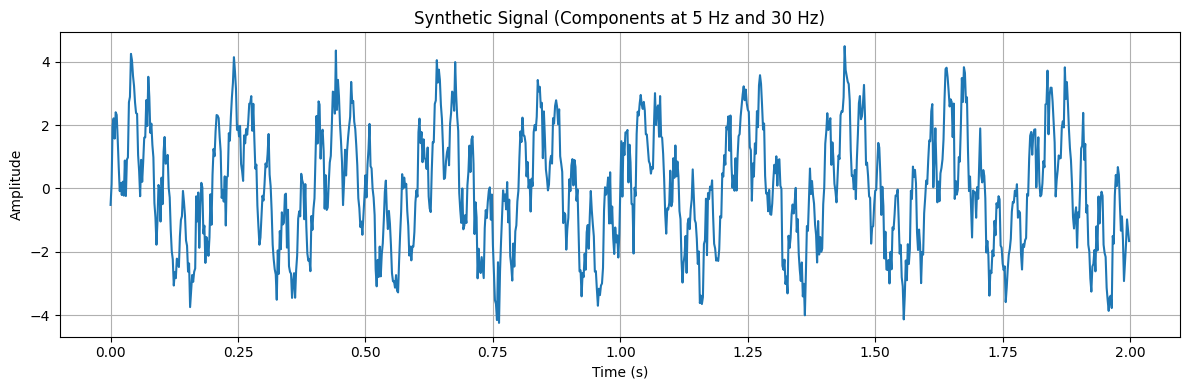

In [10]:
# Plot the synthetic signal
plt.figure(figsize=(12, 4))
plt.plot(t, signal)
plt.title(f'Synthetic Signal (Components at {f1} Hz and {f2} Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()


### **3. Empirical Mode Decomposition (EMD):**

EMD iteratively decomposes the signal into Intrinsic Mode Functions (IMFs). EMD is generally sensitive to noise and lacks the mathematical foundation of VMD.

**Key Parameter:** `max_imf` (maximum number of IMFs to extract)


EMD extracted 7 Intrinsic Mode Functions (IMFs).


ValueError: x and y must have same first dimension, but have shapes (2000,) and (1000,)

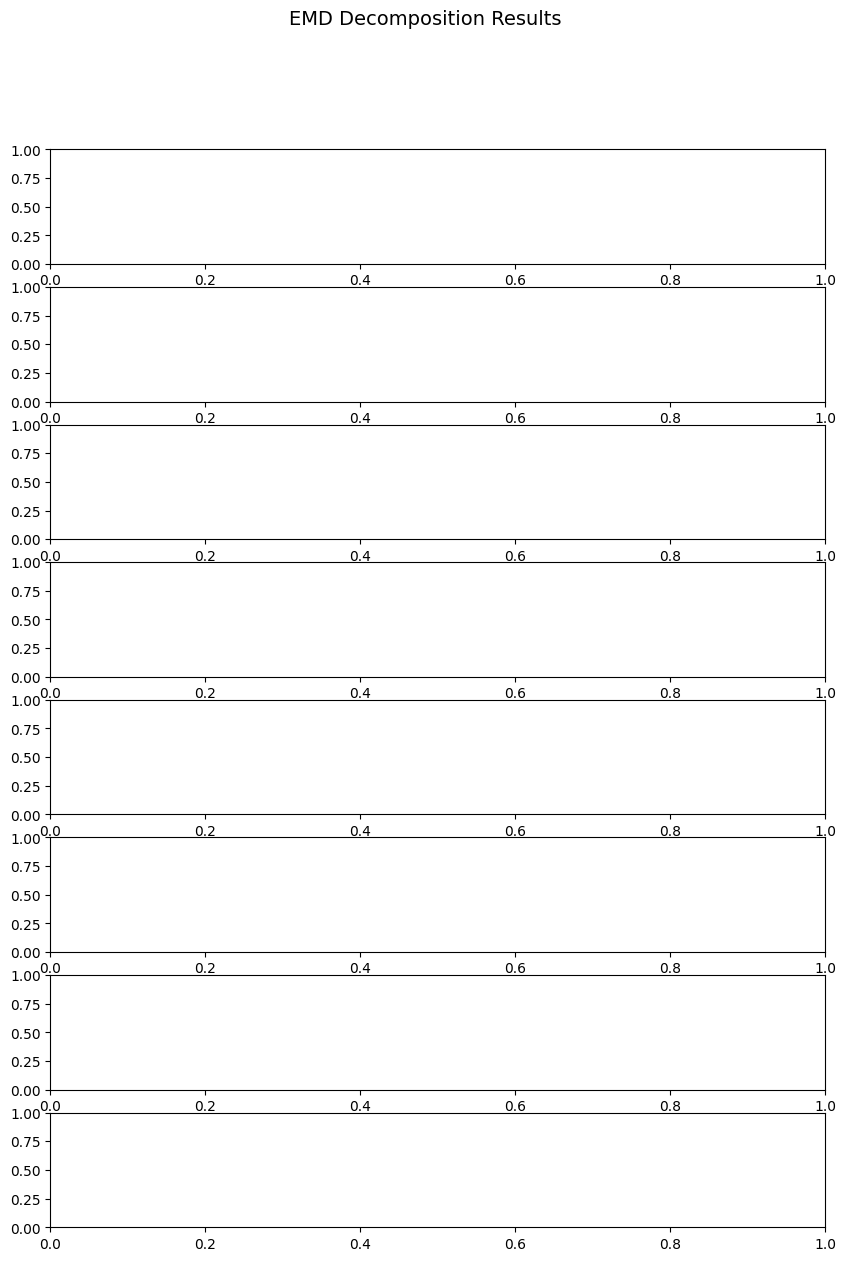

In [14]:
# Initialize EMD
emd = EMD()

# Run EMD on the signal
# max_imf=10 is used as a typical limit, but EMD is data-driven, so the number of IMFs varies.
IMFs = emd.emd(signal, max_imf=10) 

# --- Visualization ---
print(f"EMD extracted {IMFs.shape[0]} Intrinsic Mode Functions (IMFs).")

fig, axes = plt.subplots(IMFs.shape[0] + 1, 1, figsize=(10, 2 * IMFs.shape[0]))
fig.suptitle('EMD Decomposition Results', fontsize=14)

# Plot Original Signal
axes[0].plot(t, signal)
axes[0].set_title('Original Signal')
axes[0].set_xlim(t[0], t[-1])
axes[0].grid(True)

# Plot IMFs
for n, imf in enumerate(IMFs):
    axes[n + 1].plot(t, imf, 'g')
    axes[n + 1].set_title(f"IMF {n+1}")
    axes[n + 1].set_xlim(t[0], t[-1])
    axes[n + 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



### **3. Variational Mode Decomposition (VMD):**

VMD decomposes the signal into modes by iteratively updating the modes and their central frequencies, solving an optimization problem. It requires *a priori* setting of the number of modes.

**Key Parameters:**

  * `alpha`: **Bandwidth limit** (Balance between mode decomposition and fidelity). A larger $\alpha$ means a smaller bandwidth (tighter modes). Typical range: 500 to 3000 for biomedical signals.
  * `tau`: **Dual ascent time step** (Controls convergence speed/noise robustness). Default is 0.
  * `K`: **Number of modes** to be extracted. Based on the signal's known complexity (here, 2 components + a residual/noise mode, so we use K=3).


In [ ]:

# --- VMD Parameters ---
vmd_alpha = 2000    # Larger alpha = smaller bandwidth for modes
vmd_tau   = 0       # Noise-robustness (0 for quadratic penalty)
vmd_K     = 3       # Number of modes
vmd_DC    = 0       # 0 = no DC component
vmd_init  = 1       # 0 = all zeros, 1 = random, etc.
vmd_tol   = 1e-7    # Convergence tolerance

In [ ]:
# Run VMD
modes, omega, _ = VMD(signal, vmd_alpha, vmd_tau, vmd_K, vmd_DC, vmd_init, vmd_tol)



In [ ]:
# --- Visualization ---
print(f"VMD extracted {modes.shape[0]} modes.")
print(f"Estimated Central Frequencies (in radians/sample): {omega}")
# Convert central frequencies to Hz for easy interpretation:
omega_hz = omega * Fs / (2 * np.pi)
print(f"Estimated Central Frequencies (in Hz): {omega_hz}")



VMD extracted 3 modes.
Estimated Central Frequencies (in radians/sample): [[ 0.12378839-3.19189120e-16j  0.00607267+5.55111512e-17j
  -0.12695622-2.77555756e-17j]
 [ 0.15184209+6.57639998e-02j  0.06604227+1.40382873e-01j
   0.49476669+1.45554189e+00j]
 [ 0.09238713+1.85417947e-03j -0.06108026+3.55927892e-03j
  -0.82515146+3.67315305e-02j]
 ...
 [ 0.14698857+1.84620528e-03j  0.05572999+4.56015245e-03j
   0.39245876+4.80452068e-02j]
 [ 0.09238713-1.85417947e-03j -0.06108026-3.55927892e-03j
  -0.82515146-3.67315305e-02j]
 [ 0.15184209-6.57639998e-02j  0.06604227-1.40382873e-01j
   0.49476669-1.45554189e+00j]]
Estimated Central Frequencies (in Hz): [[  9.85076705-2.54002631e-14j   0.48324787+4.41743706e-15j
  -10.10285473-2.20871853e-15j]
 [ 12.08320966+5.23333282e+00j   5.25547666+1.11713141e+01j
   39.37228205+1.15828343e+02j]
 [  7.35193387+1.47550914e-01j  -4.86061299+2.83238417e-01j
  -65.66346712+2.92300233e+00j]
 ...
 [ 11.69697885+1.46916348e-01j   4.43485202+3.62885402e-01j
   31.

ValueError: x and y must have same first dimension, but have shapes (2000,) and (2, 2000)

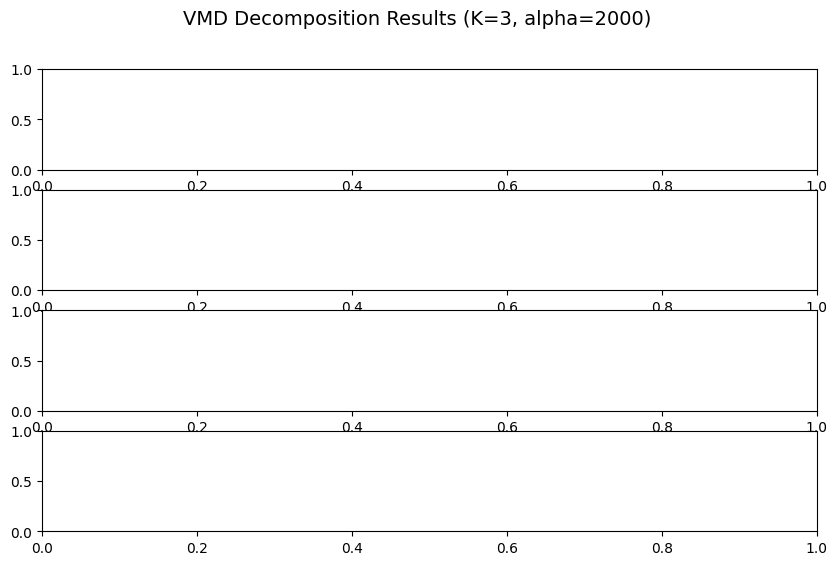

In [ ]:
fig, axes = plt.subplots(modes.shape[0] + 1, 1, figsize=(10, 2 * modes.shape[0]))
fig.suptitle(f'VMD Decomposition Results (K={vmd_K}, alpha={vmd_alpha})', fontsize=14)

axes[0].plot(t, signal)
axes[0].set_title('Original Signal')
axes[0].set_xlim(t[0], t[-1])
axes[0].grid(True)

for n, mode in enumerate(modes):
    axes[n + 1].plot(t, mode.real, 'r')

    # FIX: take the average of the instantaneous frequencies
    center_freq_real = np.mean(omega_hz[n].real)

    axes[n + 1].set_title(f"Mode {n+1} (Center Freq: {center_freq_real:.2f} Hz)")
    axes[n + 1].set_xlim(t[0], t[-1])
    axes[n + 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

ValueError: x and y must have same first dimension, but have shapes (4000,) and (2, 2000)

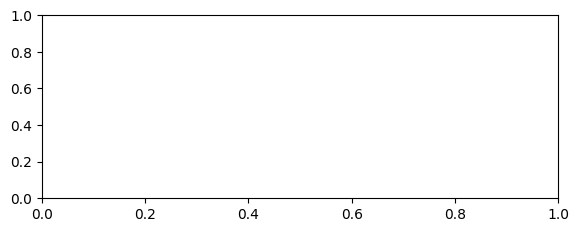

In [ ]:
plot_vmd_modes(modes, signal, Fs, omega_hz=omega_hz)

In [ ]:
T = 2000
C = 2
t = np.linspace(0, 1, T)

# Example multichannel signal (you can replace with your own)
signal_np = np.stack([
    np.sin(2*np.pi*10*t) + 0.3*np.random.randn(T),
    np.sin(2*np.pi*15*t) + 0.3*np.random.randn(T)
])

# Convert to torch tensor
signal_multi = torch.tensor(signal_np, dtype=torch.float32)

plt.figure(figsize=(12, 5))

# Plot each channel separately
for c in range(C):
    plt.plot(t, signal_np[c], label=f'Channel {c+1}')

plt.title('Synthetic Multichannel Signal (10 Hz and 15 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### **4. Multivariate Variational Mode Decomposition (MVMD):**

MVMD extends VMD to **multichannel signals**, decomposing all channels **jointly** while enforcing a *shared central frequency* for each mode. This allows the algorithm to capture common oscillatory components across channels, improving stability and reducing mode misalignment.

**Key Parameters:**

* `alpha`: **Bandwidth constraint** (same role as in VMD). Larger values yield narrower-band, more stable multichannel modes.
* `tau`: **Dual ascent step** controlling convergence. Typically set to 0.
* `K`: **Number of modes** to extract. Chosen according to the number of expected oscillatory components (e.g., 2 components + noise → K=3).
* `DC`: Include/exclude a **zero-frequency mode** (0 = no DC).
* `init`: Initialization method for center frequencies (0: zeros, 1: uniform, 2: random).
* `tol`: Convergence tolerance (smaller values = higher precision).


This exemple uses the custom `mvmd_torch` function that requires PyTorch to handle the multi-channel optimization efficiently. You can find this new implementation above in this notebook.

In [ ]:
# Check for CUDA availability
if torch.cuda.is_available():
    print("CUDA is available. Using GPU acceleration.")
    DEVICE = torch.device("cuda")
else:
    print("CUDA not available. Using CPU.")
    DEVICE = torch.device("cpu")
    
# Convert the MVMD function to use NumPy/CPU for broad compatibility in this demo
# Note: For real-world MEG data, use the original GPU logic!


CUDA not available. Using CPU.


In [ ]:

# MVMD parameters
alpha = 2000
tau = 0
K = 2
DC = False
init = 1
tol = 1e-7
max_N = 500

In [ ]:
# Run MVMD
u_real, u_hat_final, omega = mvmd_torch(signal, alpha, tau, K, DC, init, tol, max_N)

print("Decomposition complete!")
print("u_real shape:", u_real.shape)


MVMD converged in 5 iterations.
Decomposition complete!
u_real shape: torch.Size([2, 2000, 2])


/var/folders/_p/stbgbx154_v2mk71nn05yw5r0000gn/T/ipykernel_58091/623362495.py:242: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


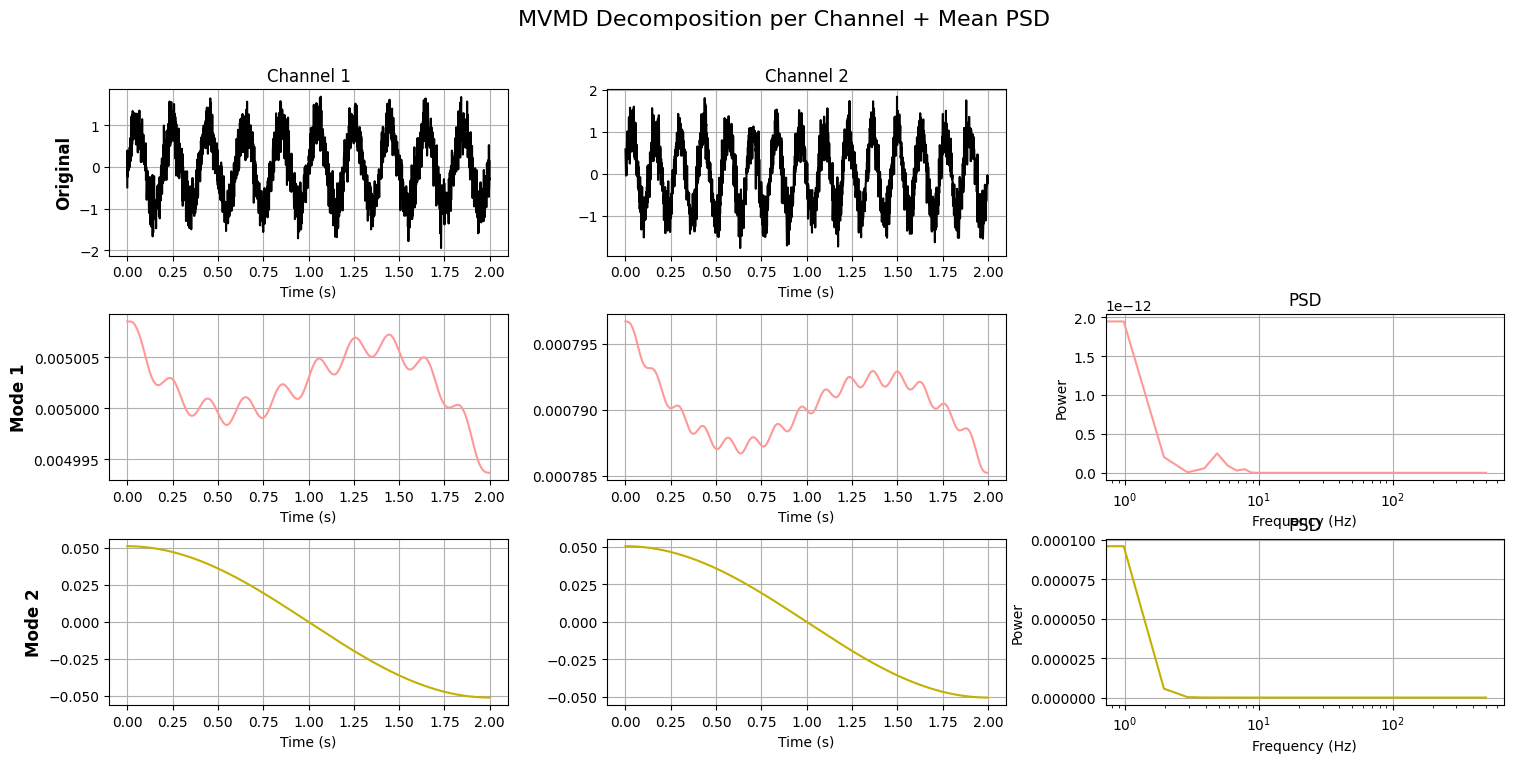

In [ ]:
# signal must be shaped (C, T)
original_signal = signal.cpu().numpy()

plot_mvmd_results(u_real.cpu().numpy(), original_signal, Fs=1000)